# Main Thread

Import Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Datasets/Geotif(6).zip" -d '/content/LandCoverData'  

Archive:  /content/drive/MyDrive/Datasets/Geotif(6).zip
   creating: /content/LandCoverData/Geotif(6)/
   creating: /content/LandCoverData/Geotif(6)/Image/
  inflating: /content/LandCoverData/Geotif(6)/Image/M-33-20-D-c-4-2.tif  
  inflating: /content/LandCoverData/Geotif(6)/Image/M-33-20-D-d-3-3.tif  
  inflating: /content/LandCoverData/Geotif(6)/Image/M-33-32-B-b-4-4.tif  
  inflating: /content/LandCoverData/Geotif(6)/Image/M-33-48-A-c-4-4.tif  
  inflating: /content/LandCoverData/Geotif(6)/Image/M-33-7-A-d-2-3.tif  
  inflating: /content/LandCoverData/Geotif(6)/Image/M-33-7-A-d-3-2.tif  
   creating: /content/LandCoverData/Geotif(6)/Masks/
  inflating: /content/LandCoverData/Geotif(6)/Masks/M-33-20-D-c-4-2.tif  
  inflating: /content/LandCoverData/Geotif(6)/Masks/M-33-20-D-d-3-3.tif  
  inflating: /content/LandCoverData/Geotif(6)/Masks/M-33-32-B-b-4-4.tif  
  inflating: /content/LandCoverData/Geotif(6)/Masks/M-33-48-A-c-4-4.tif  
  inflating: /content/LandCoverData/Geotif(6)/Masks/M

In [4]:
!pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-8ldnrncx
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-8ldnrncx
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 3.2 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=21876fab6230a4271cf7ff2befb1ffc430dc2a495a4f79079f14605f7c61e895
  Stored in directory: /tmp/pip-ephem-wheel-cache-kdl7s52h/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [5]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
tf.compat.v1.disable_eager_execution()

In [6]:
import os
import cv2
import numpy as np
import glob
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random


Segmentation Models: using `keras` framework.


# Preprocessing

Labels are:  [0 1 2 3 4]  and the counts are:  [18008335    46512 59476087  9553859   554627]


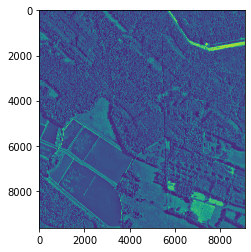

In [ ]:
#Quick understanding of the dataset
temp_img = cv2.imread("/content/LandCoverData/Geotif(6)/Image/M-33-20-D-c-4-2.tif") #3 channels / spectral bands
plt.imshow(temp_img[:,:,2]) #View each channel...
temp_mask = cv2.imread("/content/LandCoverData/Geotif(6)/Masks/M-33-20-D-c-4-2.tif") #3 channels but all same. 
labels, count = np.unique(temp_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)

In [ ]:

#Now, crop each large image into patches of 256x256. Save them into a directory 
#so we can use data augmentation and read directly from the drive. 
!mkdir '/content/Patch'
!mkdir '/content/Patch/images'
!mkdir '/content/Patch/masks'

patch_size = 256

mkdir: cannot create directory ‘/content/Patch’: File exists
mkdir: cannot create directory ‘/content/Patch/images’: File exists
mkdir: cannot create directory ‘/content/Patch/masks’: File exists


In [ ]:
#Read images from repsective 'images' subdirectory
#As all images are of different size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
img_dir= "/content/LandCoverData/Geotif(6)/Image/"
for path, subdirs, files in os.walk(img_dir):
    print(path)  
    dirname = path.split(os.path.sep)[-1]
    #print(dirname)
    images = os.listdir(path)  #List of all image names in this subdirectory
    #print(images)
    for i, image_name in enumerate(images):  
        if image_name.endswith(".tif"):
            #print(image_name)
            image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
            SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            image = Image.fromarray(image)
            image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            image = np.array(image)             
   
            #Extract patches from each image
            print("patching image:", path+"/"+image_name)
            patches_img = patchify(image, (256, 256, 3), step=256)  #Step=256 for 256 patches means no overlap
    
            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    
                    single_patch_img = patches_img[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #We will preprocess using one of the backbones
                    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                    
                    cv2.imwrite("/content/Patch/images/"+
                               image_name+"patch_"+str(i)+str(j)+".tif", single_patch_img)
                    #image_dataset.append(single_patch_img)
            
  
 


/content/LandCoverData/Geotif(6)/Image/

['M-33-7-A-d-3-2.tif', 'M-33-20-D-c-4-2.tif', 'M-33-48-A-c-4-4.tif', 'M-33-20-D-d-3-3.tif', 'M-33-7-A-d-2-3.tif', 'M-33-32-B-b-4-4.tif']
Now patchifying image: /content/LandCoverData/Geotif(6)/Image//M-33-7-A-d-3-2.tif
Now patchifying image: /content/LandCoverData/Geotif(6)/Image//M-33-20-D-c-4-2.tif
Now patchifying image: /content/LandCoverData/Geotif(6)/Image//M-33-48-A-c-4-4.tif
Now patchifying image: /content/LandCoverData/Geotif(6)/Image//M-33-20-D-d-3-3.tif
Now patchifying image: /content/LandCoverData/Geotif(6)/Image//M-33-7-A-d-2-3.tif
Now patchifying image: /content/LandCoverData/Geotif(6)/Image//M-33-32-B-b-4-4.tif


In [ ]:
#Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dir= "/content/LandCoverData/Geotif(6)/Masks/"
for path, subdirs, files in os.walk(mask_dir):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]

    masks = os.listdir(path)  #List of all image names in this subdirectory
    for i, mask_name in enumerate(masks):  
        if mask_name.endswith(".tif"):           
            mask = cv2.imread(path+"/"+mask_name, 0)  #Read each image as Grey (or color but remember to map each color to an integer)
            SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            mask = Image.fromarray(mask)
            mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            mask = np.array(mask)             
   
            #Extract patches from each image
            print("patching mask:", path+"/"+mask_name)
            patches_mask = patchify(mask, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    
            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                    
                    single_patch_mask = patches_mask[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                    #single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                    cv2.imwrite("/content/Patch/masks/"+
                               mask_name+"patch_"+str(i)+str(j)+".tif", single_patch_mask)

patching mask: /content/LandCoverData/Geotif(6)/Masks//M-33-7-A-d-3-2.tif
patching mask: /content/LandCoverData/Geotif(6)/Masks//M-33-20-D-c-4-2.tif
patching mask: /content/LandCoverData/Geotif(6)/Masks//M-33-48-A-c-4-4.tif
patching mask: /content/LandCoverData/Geotif(6)/Masks//M-33-20-D-d-3-3.tif
patching mask: /content/LandCoverData/Geotif(6)/Masks//M-33-7-A-d-2-3.tif
patching mask: /content/LandCoverData/Geotif(6)/Masks//M-33-32-B-b-4-4.tif


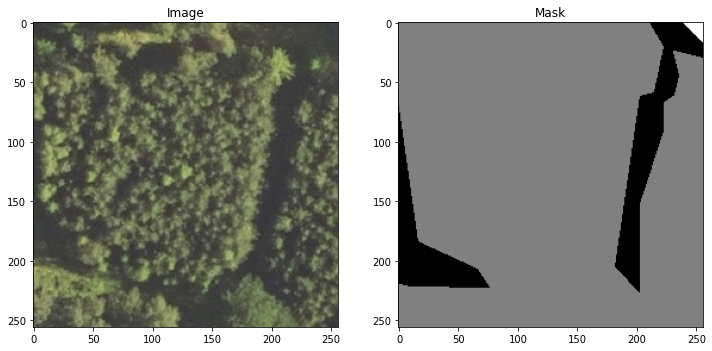

In [ ]:
train_img_dir = "/content/Patch/images/"
train_mask_dir = "/content/Patch/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()


In [ ]:
!mkdir '/content/Selected_Patch'
!mkdir '/content/Selected_Patch/images'
!mkdir '/content/Selected_Patch/masks'

In [ ]:
#Now, let us copy images and masks with real information to a new folder.
# real information = if mask has decent amount of labels other than 0. 

useless=0  #Useless image counter
for img in range(len(img_list)):   #Using t1_list as all lists are of same size
    img_name=img_list[img]
    mask_name = msk_list[img]
    print("image and masks number: ", img, "of", len(img_list))
      
    temp_image=cv2.imread(train_img_dir+img_list[img], 1)
   
    temp_mask=cv2.imread(train_mask_dir+msk_list[img], 0)
    #temp_mask=temp_mask.astype(np.uint8)
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.05:  #At least 5% useful area with labels that are not 0
        print("Save")
        cv2.imwrite('/content/Selected_Patch/images/'+img_name, temp_image)
        cv2.imwrite('/content/Selected_Patch/masks/'+mask_name, temp_mask)
        
    else:
        print("Delete")   
        useless +=1

print("Total useful images are: ", len(img_list)-useless)  #20,075
print("Total useless images are: ", useless) #21,571
###############################################################

Streaming output truncated to the last 5000 lines.
image and masks number:  4786 of 7285
Delete
image and masks number:  4787 of 7285
Delete
image and masks number:  4788 of 7285
Delete
image and masks number:  4789 of 7285
Save
image and masks number:  4790 of 7285
Save
image and masks number:  4791 of 7285
Save
image and masks number:  4792 of 7285
Delete
image and masks number:  4793 of 7285
Save
image and masks number:  4794 of 7285
Save
image and masks number:  4795 of 7285
Delete
image and masks number:  4796 of 7285
Save
image and masks number:  4797 of 7285
Delete
image and masks number:  4798 of 7285
Save
image and masks number:  4799 of 7285
Save
image and masks number:  4800 of 7285
Delete
image and masks number:  4801 of 7285
Delete
image and masks number:  4802 of 7285
Delete
image and masks number:  4803 of 7285
Delete
image and masks number:  4804 of 7285
Save
image and masks number:  4805 of 7285
Save
image and masks number:  4806 of 7285
Delete
image and masks number: 

In [ ]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir '/content/Split_Data'

In [ ]:
#Now split the data into training, validation and testing. 

"""
Code for splitting folder into train, test, and val.
Once the new folders are created rename them and arrange in the format below to be used
for semantic segmentation using data generators. 
pip install split-folders
"""
import splitfolders  # or import split_folders

input_folder = '/content/Selected_Patch/'
output_folder =  '/content/Split_Data/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.80, .20), group_prefix=None) # default values
########################################

Copying files: 7610 files [00:02, 2604.02 files/s]


In [ ]:
!mkdir '/content/Data'
!mkdir '/content/Data/train_images/'
!mkdir '/content/Data/train_masks/'
!mkdir '/content/Data/val_images/'
!mkdir '/content/Data/val_masks/'
!mkdir '/content/Data/train_images/train/'
!mkdir '/content/Data/train_masks/train/'
!mkdir '/content/Data/val_images/val/'
!mkdir '/content/Data/val_masks/val/'

In [ ]:
!mv /content/Split_Data/train/images/*.tif '/content/Data/train_images/train/'
!mv /content/Split_Data/train/masks/*.tif '/content/Data/train_masks/train/'
!mv /content/Split_Data/val/images/*.tif '/content/Data/val_images/val/'
!mv /content/Split_Data/val/masks/*.tif '/content/Data/val_masks/val/'

mv: cannot stat '/content/Split_Data/train/images/*.tif': No such file or directory
mv: cannot stat '/content/Split_Data/train/masks/*.tif': No such file or directory
mv: cannot stat '/content/Split_Data/val/masks/*.tif': No such file or directory


In [ ]:
!mv /content/Split_Data/train/images/*.tif '/content/drive/MyDrive/Datasets/Satellite image multiclass segmentation\/train_images/train/'
!mv /content/Split_Data/train/masks/*.tif '/content/drive/MyDrive/Datasets/Satellite image multiclass segmentation\/train_masks/train/'
!mv /content/Split_Data/val/images/*.tif '/content/drive/MyDrive/Datasets/Satellite image multiclass segmentation\/val_images/val/'
!mv /content/Split_Data/val/masks/*.tif '/content/drive/MyDrive/Datasets/Satellite image multiclass segmentation\/val_masks/val/'

Image Data Generator

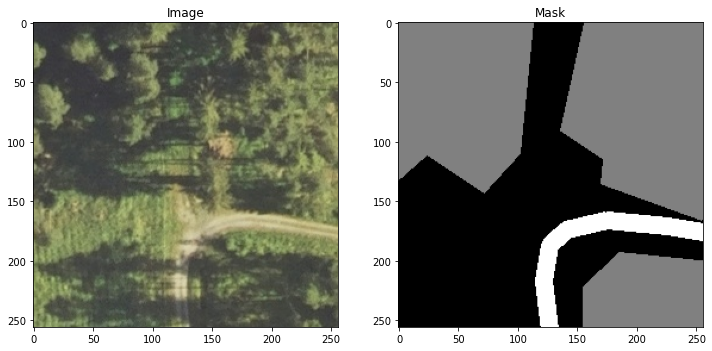

In [ ]:
################################################################
#Get an understanding by looking at a few random images and masks 

train_img_dir = "/content/drive/MyDrive/Datasets/Satellite image multiclass segmentation\/train_images/train/"
train_mask_dir = "/content/drive/MyDrive/Datasets/Satellite image multiclass segmentation\/train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

################################################################

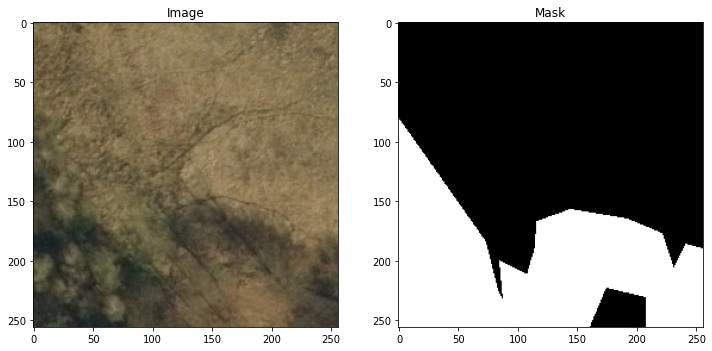

In [ ]:
################################################################
#Get an understanding by looking at a few random images and masks 

train_img_dir = "/content/Data/train_images/train/"
train_mask_dir = "/content/Data/train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

################################################################

# Model

In [7]:
# Define Generator for images and masks so we can read them directly from the drive. 

seed=24
batch_size= 16
n_classes=5

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from tensorflow.keras.utils import to_categorical

#Use this to preprocess input for transfer learning
BACKBONE = 'resnet18'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [8]:
#Define a function to perform additional preprocessing after datagen.
#For example, scale images, convert masks to categorical, etc. 
def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    #Convert mask to one-hot
    mask = to_categorical(mask, num_class)
      
    return (img,mask)

In [9]:
#Define the generator.
#We are not doing any rotation or zoom to make sure mask values are not interpolated.
#It is important to keep pixel values in mask as 0, 1, 2, 3, .....
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)


For testing from drive

In [10]:
train_img_path = "/content/drive/MyDrive/Datasets/Satellite image multiclass segmentation\/train_images/"
train_mask_path = "/content/drive/MyDrive/Datasets/Satellite image multiclass segmentation\/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=5)

Normal

In [ ]:
train_img_path = "/content/Data/train_images/"
train_mask_path = "/content/Data/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=5)



For testing from drive

In [11]:
val_img_path = "/content/drive/MyDrive/Datasets/Satellite image multiclass segmentation\/val_images/"
val_mask_path = "/content/drive/MyDrive/Datasets/Satellite image multiclass segmentation\/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=5)

Normal

In [ ]:
val_img_path = "/content/Data/val_images/"
val_mask_path = "/content/Data/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=5)

Found 3044 images belonging to 1 classes.
Found 3044 images belonging to 1 classes.


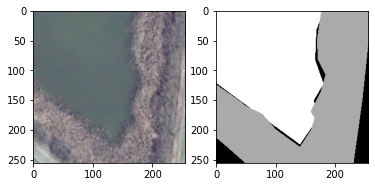

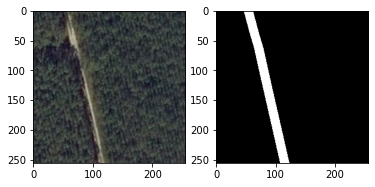

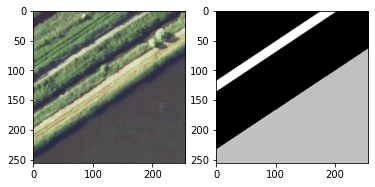

In [15]:
#Make sure the generator is working and that images and masks are indeed lined up. 
#Verify generator.... In python 3 next() is renamed as __next__()
x, y = train_img_gen.__next__()

for i in range(0,3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

Found 761 images belonging to 1 classes.
Found 761 images belonging to 1 classes.


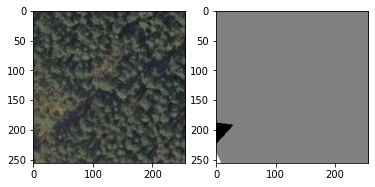

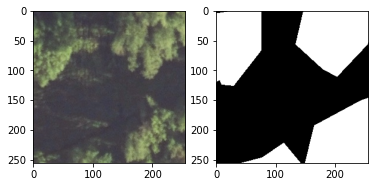

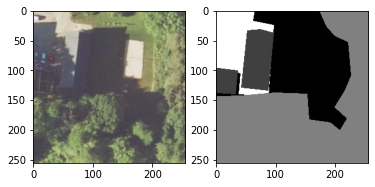

In [16]:
x_val, y_val = val_img_gen.__next__()

for i in range(0,3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()


For testing from drive

In [17]:
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir('/content/drive/MyDrive/Datasets/Satellite image multiclass segmentation\/train_images/train/'))
num_val_images = len(os.listdir('/content/drive/MyDrive/Datasets/Satellite image multiclass segmentation\/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size


IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes=5

Normal

In [ ]:
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir('/content/Data/train_images/train/'))
num_val_images = len(os.listdir('/content/Data/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size


IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes=5


In [13]:
sm.set_framework('tf.keras')

sm.framework()


'tf.keras'

In [29]:
#Define the model
# define model
model = sm.Linknet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])


In [ ]:
#Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
print(model.summary())
print(model.input_shape)
#Fit the model

In [23]:
for layer in model.layers:
    layer.trainable = True 

In [ ]:
for layer in model.layers:
    print(layer, layer.trainable)

In [30]:
#history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=len(X_train) // 16, validation_steps=len(X_train) // 16, epochs=100)
#Train the model. 
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=1,
          #run_eagerly=True,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)


Epoch 1/10
190/190 [==============================] - ETA: 0s - batch: 94.5000 - size: 15.9368 - loss: 0.7198 - iou_score: 0.3169

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


190/190 [==============================] - 2023s 11s/step - batch: 94.5000 - size: 15.9368 - loss: 0.7198 - iou_score: 0.3169 - val_loss: 1.2046 - val_iou_score: 0.0949
Epoch 2/10
190/190 [==============================] - 1996s 11s/step - batch: 94.5000 - size: 15.9368 - loss: 0.6339 - iou_score: 0.4043 - val_loss: 1.6219 - val_iou_score: 0.0182
Epoch 3/10
190/190 [==============================] - 2031s 11s/step - batch: 94.5000 - size: 15.9368 - loss: 0.5998 - iou_score: 0.4375 - val_loss: 1.6058 - val_iou_score: 0.0198
Epoch 4/10
190/190 [==============================] - 2006s 11s/step - batch: 94.5000 - size: 15.9368 - loss: 0.5743 - iou_score: 0.4610 - val_loss: 1.5837 - val_iou_score: 0.0196
Epoch 5/10
190/190 [==============================] - 2079s 11s/step - batch: 94.5000 - size: 15.9368 - loss: 0.5171 - iou_score: 0.5175 - val_loss: 0.9683 - val_iou_score: 0.1862
Epoch 6/10
190/190 [==============================] - 2005s 11s/step - batch: 94.5000 - size: 15.9368 - loss: 0

In [34]:
model.save('/content/drive/MyDrive/Datasets/landcover_10_epochs_RESNET_backbone_batch16.h5')

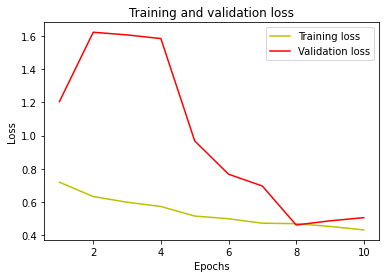

In [31]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

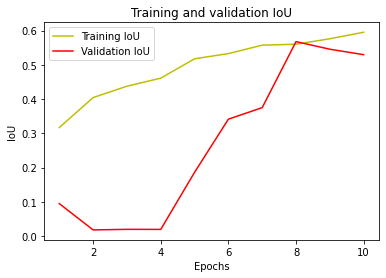

In [33]:
plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [40]:
from keras.models import load_model

model1 = load_model("/content/drive/MyDrive/Datasets/landcover_10_epochs_RESNET_backbone_batch16.h5", custom_objects={'focal_loss_plus_jaccard_loss': sm.losses.categorical_focal_jaccard_loss,'iou_score': sm.metrics.iou_score})

#batch_size=32 #Check IoU for a batch of images


In [1]:
history=model1.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=1,
          #run_eagerly=True,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)

NameError: ignored

In [ ]:
#Test generator using validation data.

test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 5
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

InvalidArgumentError: ignored

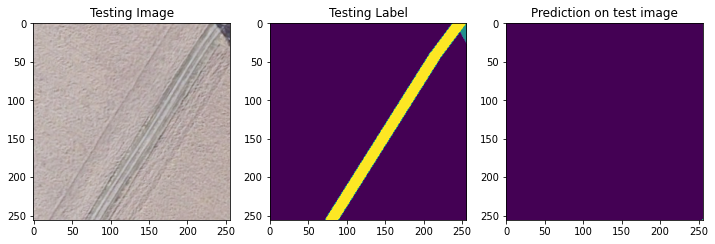

In [ ]:
#View a few images, masks and corresponding predictions. 
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()